# Quora Question Pairs- Kaggle Competetion

## 1.0 Requirements

In [1]:
pip install num2words

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 kB 3.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pydot graphviz

Note: you may need to restart the kernel to use updated packages.


## 2.0 Imports

In [3]:
#basics
import numpy as np
import pandas as pd

#visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import plot_model

#text_processing
from num2words import num2words
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from nltk.stem import SnowballStemmer

#data preperation
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Neural Network
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Embedding, LSTM, Dropout, concatenate, Input, Dense
from tensorflow.keras.layers import Bidirectional, Attention, Reshape, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#other
from tqdm import tqdm
import gc

#warnings
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
import tensorflow as tf
print(tf.__version__)

2.12.0


## 3.0 Dependencies

In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

## 4.0 Data Understanding

In [9]:
seed=42
chunk_size=50000
batch_size=2048
TRAIN_DATA_PATH='/kaggle/input/quora-question-pairs/train.csv.zip'
TEST_DATA_PATH='/kaggle/input/quora-question-pairs/test.csv'
SUB_DATA='/kaggle/input/quora-question-pairs/sample_submission.csv.zip'
GLOVE='/kaggle/input/googlevectors/glove.6B.200d.txt'

In [10]:
df = pd.read_csv(TRAIN_DATA_PATH)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [11]:
print('df shape:', df.shape)

df shape: (404290, 6)


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [13]:
df.isna().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [14]:
df.dropna(inplace=True)

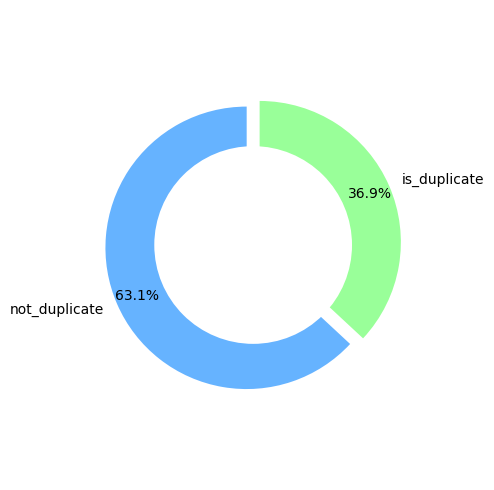

In [15]:
# number of customers who churned and who did not churn
targets = df['is_duplicate'].value_counts()

# pie chart to visualize the distribution of customer churn
labels = ['not_duplicate', 'is_duplicate']
sizes = targets.values.tolist()

#colors
colors = ['#66b3ff', '#99ff99'] 

 
fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = (0.05,0.05))
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout();

## 5.0 Data Preprocessing

In [16]:
#lower casing
def lower_casing(text):
  text=text.lower()

  return text

In [17]:
df['new_ques1']=df['question1'].apply(lower_casing)
df['new_ques2']=df['question2'].apply(lower_casing)

In [18]:
#replacing symbols and short forms
def replacements(text):

    text=text.replace('=', ' is equal to ')
    text=text.replace('%', ' percent ')
    text = text.replace('$', ' dollar ')
    text = text.replace('₹', ' rupee ')
    text = text.replace('€', ' euro ')
    text = text.replace('@', ' at ')
    text = text.replace('+', ' plus ')
    text = text.replace('/', ' or ')
    text = text.replace('-', ' ')
    text = text.replace('[math]', '')
    
    #replacement dict
    replacements_dict = {
        "ain't": "am not",
        "aren't": "are not",
        "can't": "can not",
        "can't've": "can not have",
        "'cause": "because",
        "could've": "could have",
        "couldn't": "could not",
        "couldn't've": "could not have",
        "didn't": "did not",
        "doesn't": "does not",
        "don't": "do not",
        "hadn't": "had not",
        "hadn't've": "had not have",
        "hasn't": "has not",
        "haven't": "have not",
        "he'd": "he would",
        "he'd've": "he would have",
        "he'll": "he will",
        "he'll've": "he will have",
        "he's": "he is",
        "how'd": "how did",
        "how'd'y": "how do you",
        "how'll": "how will",
        "how's": "how is",
        "I'd": "I would",
        "I'd've": "I would have",
        "I'll": "I will",
        "I'll've": "I will have",
        "I'm": "I am",
        "I've": "I have",
        "isn't": "is not",
        "it'd": "it would",
        "it'd've": "it would have",
        "it'll": "it will",
        "it'll've": "it will have",
        "it's": "it is",
        "let's": "let us",
        "ma'am": "madam",
        "mayn't": "may not",
        "might've": "might have",
        "mightn't": "might not",
        "mightn't've": "might not have",
        "must've": "must have",
        "mustn't": "must not",
        "mustn't've": "must not have",
        "needn't": "need not",
        "needn't've": "need not have",
        "o'clock": "of the clock",
        "oughtn't": "ought not",
        "oughtn't've": "ought not have",
        "shan't": "shall not",
        "sha'n't": "shall not",
        "shan't've": "shall not have",
        "she'd": "she would",
        "she'd've": "she would have",
        "she'll": "she will",
        "she'll've": "she will have",
        "she's": "she is",
        "should've": "should have",
        "shouldn't": "should not",
        "shouldn't've": "should not have",
        "so've": "so have",
        "so's": "so is",
        "that'd": "that would",
        "that'd've": "that would have",
        "that's": "that is",
        "there'd": "there would",
        "there'd've": "there would have",
        "there's": "there is",
        "they'd": "they would",
        "they'd've": "they would have",
        "they'll": "they will",
        "they'll've": "they will have",
        "they're": "they are",
        "they've": "they have",
        "to've": "to have",
        "wasn't": "was not",
        "we'd": "we would",
        "we'd've": "we would have",
        "we'll": "we will",
        "we'll've": "we will have",
        "we're": "we are",
        "we've": "we have",
        "weren't": "were not",
        "what'll": "what will",
        "what'll've": "what will have",
        "what're": "what are",
        "what's": "what is",
        "what've": "what have",
        "when's": "when is",
        "when've": "when have",
        "where'd": "where did",
        "where's": "where is",
        "where've": "where have",
        "who'll": "who will",
        "who'll've": "who will have",
        "who's": "who is",
        "who've": "who have",
        "why's": "why is",
        "why've": "why have",
        "will've": "will have",
        "won't": "will not",
        "won't've": "will not have",
        "would've": "would have",
        "wouldn't": "would not",
        "wouldn't've": "would not have",
        "y'all": "you all",
        "y'all'd": "you all would",
        "y'all'd've": "you all would have",
        "y'all're": "you all are",
        "y'all've": "you all have",
        "you'd": "you would",
        "you'd've": "you would have",
        "you'll": "you will",
        "you'll've": "you will have",
        "you're": "you are",
        "you've": "you have",
    }

    # Apply replacements
    pattern = re.compile(r'\b(' + '|'.join(replacements_dict.keys()) + r')\b')
    text = pattern.sub(lambda x: replacements_dict[x.group()], text)

    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    
    return text

In [19]:
df['new_ques1']=df['new_ques1'].apply(replacements)
df['new_ques2']=df['new_ques2'].apply(replacements)

In [20]:
#converting numbers to words
def num_to_words(text):
  #converting numbers to words
  words = text.split()
  converted_text = []
  for word in words:
      if re.match(r'^-?\d+\.?\d*$', word):  # Check if the word is a numeric value
          try:
              converted_word = num2words(float(word))
              converted_text.append(converted_word)
          except ValueError:
              converted_text.append(word)  # If conversion fails, keep the original word
      else:
          converted_text.append(word)
  
  text=' '.join(converted_text)

  return text

In [21]:
df['new_ques1']=df['new_ques1'].apply(num_to_words)
df['new_ques2']=df['new_ques2'].apply(num_to_words)

Stemming: 
Snowball Stemming, preferred over PorterStemmer and other stemming algorithms, offers several advantages. Firstly, it supports a wide range of languages, making it suitable for multilingual datasets. Secondly, it generates more accurate stems, addressing the limitations of PorterStemmer and providing better results for word forms and variations. Additionally, Snowball Stemming allows for fine-grained control over stemming rules, making it customizable and adaptable to specific requirements.

In [22]:
stemmer = SnowballStemmer('english')

def stem_words(text):
    return ' '.join([(stemmer.stem(word.strip())).strip() for word in text.split()])

In [23]:
pbar = tqdm(total=len(df), desc='Stemming question1')
df['new_ques1'] = df['new_ques1'].apply(lambda x: (pbar.update(1), stem_words(x))[1])
pbar.close()

Stemming question1: 100%|██████████| 404287/404287 [00:43<00:00, 9291.69it/s]


In [24]:
pbar = tqdm(total=len(df), desc='Stemming question2')
df['new_ques2'] = df['new_ques2'].apply(lambda x: (pbar.update(1), stem_words(x))[1])
pbar.close()

Stemming question2: 100%|██████████| 404287/404287 [00:44<00:00, 9027.36it/s]


In [25]:
stop_words=stopwords.words('english')

def remove_stopwords(text):

    new_text=[]

    for word in text.split():

        if word in stop_words:
            new_text.append('')

        else:
            new_text.append(word.strip())

    x=new_text[:]
    new_text.clear()
    return ' '.join(x)

In [26]:
pbar = tqdm(total=len(df), desc='Removing Stopwords:')
df['new_ques1'] = df['new_ques1'].apply(lambda x: (pbar.update(1), remove_stopwords(x))[1])
df['new_ques2'] = df['new_ques2'].apply(lambda x: (pbar.update(1), remove_stopwords(x))[1])
pbar.close()

Removing Stopwords:: 808574it [00:17, 46556.08it/s]


In [27]:
example=np.random.randint(len(df))
print(df['question1'][example])
print(df['new_ques1'][example])


How can the electoral college be abolished?
   elector colleg  abolish


## 6.0 Vector Representation

In [28]:
operational_df=df[['new_ques1', 'new_ques2', 'is_duplicate']]


In [29]:
#training and testing sets
train_df, test_df = train_test_split(operational_df, test_size=0.2, random_state=seed)

In [30]:
# Tokenizing the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['new_ques1'].values + train_df['new_ques2'].values)
vocab=tokenizer.word_index

In [31]:
#preparing sequenced data
train_sequences_1 = tokenizer.texts_to_sequences(train_df['new_ques1'].values)
train_sequences_2 = tokenizer.texts_to_sequences(train_df['new_ques2'].values)
test_sequences_1 = tokenizer.texts_to_sequences(test_df['new_ques1'].values)
test_sequences_2 = tokenizer.texts_to_sequences(test_df['new_ques2'].values)

In [32]:
def get_maxlen(data):
    maxlen = 0
    for sent in data:
        maxlen = max(maxlen, len(sent))
    return maxlen

sequences=[train_sequences_1, train_sequences_2, test_sequences_1, test_sequences_2]

max_lengths=[]

for sequence in sequences:
    maxlen = get_maxlen(sequence)
    max_lengths.append(maxlen)

print('Maximum lenght of sentence is:', maxlen)

Maximum lenght of sentence is: 106


In [33]:
maxlen= 30

In [34]:
# Pad sequences to a fixed length
train_data_1 = pad_sequences(train_sequences_1, maxlen=maxlen,  padding='post')
train_data_2 = pad_sequences(train_sequences_2, maxlen=maxlen,  padding='post')
test_data_1 = pad_sequences(test_sequences_1, maxlen=maxlen,  padding='post')
test_data_2 = pad_sequences(test_sequences_2, maxlen=maxlen,  padding='post')

In [35]:
# Prepare the target labels
train_labels = train_df['is_duplicate'].values
test_labels = test_df['is_duplicate'].values

In [36]:
# Reshape the labels to match the model's output shape
train_labels_reshaped = np.expand_dims(train_labels, axis=-1)
test_labels_reshaped = np.expand_dims(test_labels, axis=-1)

In [37]:
#class weights
total_samples = len(train_labels)
class_0_count = np.sum(train_labels == 0)
class_1_count = np.sum(train_labels == 1)

weight_0 = total_samples / (2 * class_0_count)
weight_1 = total_samples / (2 * class_1_count)

class_weight = {0: weight_0, 1: weight_1}
class_weight

{0: 0.7927259090775399, 1: 1.3540412455727575}

## 7.0 GloVE Embedding

In [38]:
file=open(GLOVE,'r', encoding='utf8')

content=file.readlines()
file.close()

In [39]:
#creating word-vector dictionary
embeddings={}

for line in content:
    line = line.split()
    embeddings[line[0]] = np.array(line[1:], dtype = float)

In [40]:
def filter_glove(vocab_dict, glove_dict, wordvec_dim=200):
    '''filter out only words from GloVe dictionary which are present in our corpus'''
    embedding_matrix = np.zeros((len(vocab_dict) + 1, wordvec_dim))

    for word, i in vocab_dict.items():
        embedding_vector = glove_dict.get(word)

        if embedding_vector is not None:
        # if the words not found in the glove_dict will be all-zeros.
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

embedding_matrix= filter_glove(vocab, embeddings)

## 8.0 Neural Architecture

In [41]:
#variables
vocab_size = len(tokenizer.word_index) + 1
input_shape = (maxlen,)

In [42]:
# Defining the shared embedding layer
embedding_layer = Embedding(input_dim=vocab_size, output_dim=200,
                            weights=[embedding_matrix], input_length=maxlen,
                            trainable=True)  # Fine-tune embeddings

# Defining the input layers for question 1 and question 2
question1_input = Input(shape=input_shape, name='question1_input')
question2_input = Input(shape=input_shape, name='question2_input')

# Applying the embedding layer to both inputs
embedded_question1 = embedding_layer(question1_input)
embedded_question2 = embedding_layer(question2_input)

# Define the Bidirectional LSTM layers
lstm_layer1 = Bidirectional(LSTM(units=32, return_sequences=True))
lstm_layer2 = Bidirectional(LSTM(units=16, return_sequences=True))

# Apply the LSTM layers to both embedded questions
lstm_question1 = lstm_layer1(embedded_question1)
lstm_question2 = lstm_layer1(embedded_question2)

# Apply dropout after the first LSTM layer
dropout1 = Dropout(0.2)(lstm_question1)
dropout2 = Dropout(0.2)(lstm_question2)

# Apply batch normalization after each LSTM layer
bn1 = BatchNormalization()(dropout1)
bn2 = BatchNormalization()(dropout2)

# Apply the second LSTM layer
lstm_question1 = lstm_layer2(bn1)
lstm_question2 = lstm_layer2(bn2)

# Apply attention mechanism
attention1 = Attention()([lstm_question1, lstm_question2])
attention2 = Attention()([lstm_question2, lstm_question1])

# Concatenate the outputs of the attention layers
merged_output = concatenate([attention1, attention2])

# Flatten the merged output
flatten_output = Flatten()(merged_output)

# Add the output layer
output = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))(flatten_output)

# Creating the Siamese model
model = Model(inputs=[question1_input, question2_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [43]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 question1_input (InputLayer)   [(None, 30)]         0           []                               
                                                                                                  
 question2_input (InputLayer)   [(None, 30)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 30, 200)      15784000    ['question1_input[0][0]',        
                                                                  'question2_input[0][0]']        
                                                                                                  
 bidirectional (Bidirectional)  (None, 30, 64)       59648       ['embedding[0][0]',          

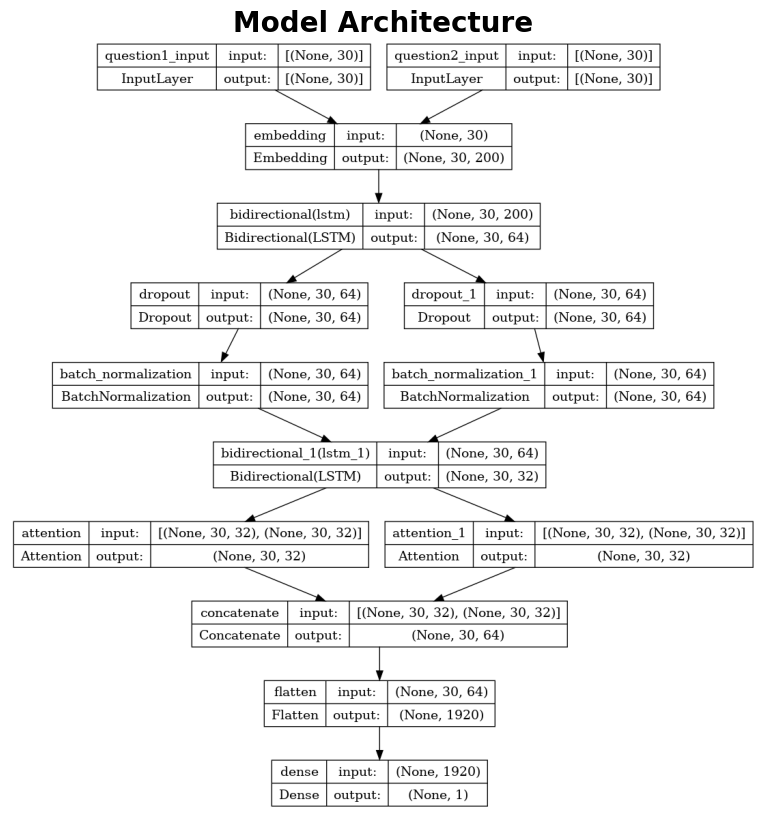

In [44]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

# Generate the model architecture plot
plot_model(model, to_file='model_architecture.png', show_shapes=True)

# Load the image and add formatting
image = plt.imread('model_architecture.png')
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image)

# Add title and remove axes
ax.set_title('Model Architecture', fontsize=20, fontweight='bold')
ax.axis('off')

# Add a border around the plot
ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(True)

# Add a background color to the plot
ax.patch.set_facecolor('#f9f9f9')
ax.patch.set_alpha(0.9)

# Save and display the plot
plt.savefig('formatted_model_architecture.png', bbox_inches='tight', pad_inches=0);

In [45]:
#model1
stopper= EarlyStopping(patience=3, monitor='val_loss')
checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=3, save_best_only=True)

history=model.fit(
        [train_data_1, train_data_2], train_labels_reshaped, 
         batch_size=2048, 
         epochs=30, 
         validation_data=([test_data_1, test_data_2], test_labels_reshaped), 
         callbacks=[stopper, checkpointer],
         class_weight=class_weight, 
         shuffle=True
         )

Epoch 1/30
158/158 [==============================] - ETA: 0s - loss: 0.5480 - accuracy: 0.7175
Epoch 1: val_loss improved from inf to 0.65055, saving model to model.weights.best.hdf5
158/158 [==============================] - 53s 230ms/step - loss: 0.5480 - accuracy: 0.7175 - val_loss: 0.6505 - val_accuracy: 0.6537
Epoch 2/30
158/158 [==============================] - ETA: 0s - loss: 0.4451 - accuracy: 0.7876
Epoch 2: val_loss improved from 0.65055 to 0.51355, saving model to model.weights.best.hdf5
158/158 [==============================] - 24s 156ms/step - loss: 0.4451 - accuracy: 0.7876 - val_loss: 0.5135 - val_accuracy: 0.7439
Epoch 3/30
158/158 [==============================] - ETA: 0s - loss: 0.3869 - accuracy: 0.8202
Epoch 3: val_loss improved from 0.51355 to 0.44416, saving model to model.weights.best.hdf5
158/158 [==============================] - 19s 121ms/step - loss: 0.3869 - accuracy: 0.8202 - val_loss: 0.4442 - val_accuracy: 0.7933
Epoch 4/30
158/158 [==================

In [46]:
#loading best model
model.load_weights('model.weights.best.hdf5')

## 9.0 Test Data

In [47]:
test_chunks=pd.read_csv(TEST_DATA_PATH, chunksize=chunk_size)

In [48]:
test = pd.DataFrame()

for chunk in tqdm(test_chunks,total=47, desc='Processing chunks:'):
    
    if len(chunk) > 0:
        # Operation 1: Drop rows with missing values
        chunk.dropna(inplace=True)

        # Operation 2: Convert to lowercase
        chunk['new_ques1'] = chunk['question1'].apply(lower_casing)
        chunk['new_ques2'] = chunk['question2'].apply(lower_casing)

        chunk=chunk.drop(columns=['question1', 'question2'])

        # Operation 3: Replace punctuation and short forms
        chunk['new_ques1'] = chunk['new_ques1'].apply(replacements)
        chunk['new_ques2'] = chunk['new_ques2'].apply(replacements)

         # Operation 4: converting numbers to text
        chunk['new_ques1'] = chunk['new_ques1'].apply(num_to_words)
        chunk['new_ques2'] = chunk['new_ques2'].apply(num_to_words)

        # Operation 5: Snowball Stemming
        chunk['new_ques1'] = chunk['new_ques1'].apply(stem_words)
        chunk['new_ques2'] = chunk['new_ques2'].apply(stem_words)

        # Operation 6: Removing Stopwords
        chunk['new_ques1'] = chunk['new_ques1'].apply(remove_stopwords)
        chunk['new_ques2'] = chunk['new_ques2'].apply(remove_stopwords)

        # Appending the processed chunk to the list
        test=pd.concat([test, chunk], ignore_index=True)
        
display(test)

Processing chunks:: 100%|██████████| 47/47 [13:16<00:00, 16.95s/it]


,test_id,new_ques1,new_ques2
0,0,doe surfac pro four compar ipad pro,whi microsoft choos core m3 core i3 home su...
1,1,hair transplant age twenty-four much wou...,much cost doe hair transplant requir
2,2,best way send money china us,send money china
3,3,food emulsifi,food fibr
4,4,aberystwyth start read,start read
...,...,...,...
2345785,2345791,peak tv seri whi leland kill laura palmer,studi scene twin peak
2345786,2345792,doe transit mean fedex track,question fedex packag deliv
2345787,2345793,famous romanian drink alcohol non alcohol,non alcohol restaur huge success
2345788,2345794,best worst thing public transit proddatu...,best worst thing examin public transit vi...


In [49]:
test_seq_que_1 = tokenizer.texts_to_sequences(test['new_ques1'].values)
test_seq_que_2 = tokenizer.texts_to_sequences(test['new_ques2'].values)

# Pad sequences to a fixed length
test_seq_que_1 = pad_sequences(test_seq_que_1, maxlen=maxlen,  padding='post')
test_seq_que_2 = pad_sequences(test_seq_que_2, maxlen=maxlen,  padding='post')

## 10.0 Prediction

In [50]:
submission=pd.read_csv(SUB_DATA)

In [51]:
pred=model.predict([test_seq_que_1, test_seq_que_2])

73306/73306 [==============================] - 565s 8ms/step


In [52]:
pred_binary=(pred > 0.5).astype(int)

In [53]:
pred_binary[:10]

array([[0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0]])

In [54]:
pred_binary.shape

(2345790, 1)

In [55]:
#extracting index which we have dropped from test data because of null values
index=set(submission.index).difference(set(test.index))
index

{2345790, 2345791, 2345792, 2345793, 2345794, 2345795}

In [56]:
#dropping these index from submission
submission.drop(index=index, inplace=True)

In [57]:
submission['test_id']=test['test_id']
submission['is_duplicate']=pred_binary

In [58]:
submission[:10]

,test_id,is_duplicate
0,0,0
1,1,0
2,2,0
3,3,0
4,4,1
5,5,0
6,6,1
7,7,1
8,8,0
9,9,0


In [59]:
# Select the first two rows
selected_rows = submission.iloc[:-2]


In [60]:
selected_rows[:10]

,test_id,is_duplicate
0,0,0
1,1,0
2,2,0
3,3,0
4,4,1
5,5,0
6,6,1
7,7,1
8,8,0
9,9,0


In [61]:
# Save the selected rows to a new CSV file
selected_rows.to_csv('selected_rows.csv', index=False) 

In [62]:
submission.to_csv('submission.csv', index=False)

In [63]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2345790 entries, 0 to 2345789
Data columns (total 2 columns):
 #   Column        Dtype
---  ------        -----
 0   test_id       int64
 1   is_duplicate  int64
dtypes: int64(2)
memory usage: 53.7 MB
